# Cello Ensemble PCA
This notebook reproduces the results related to ensemble PCA.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pathlib import Path

# Enter the locations of the sample directories
CELLO_PATH  = Path("/home/lukas/BA/philharmonia-samples/cello")
GUITAR_PATH = Path("/home/lukas/BA/philharmonia-samples/guitar")

# Output directories for figures and wavfiles
GFX_PATH    = Path("/tmp/gfx")
WAVS_PATH   = Path("/tmp/wavs")

In [2]:
# Initialization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import librosa
import pya
import random

import principal_harmonics as ph

for path in [GFX_PATH, WAVS_PATH]:
    if path.exists() and not path.is_dir():
        raise NotADirectoryError(path)
    if not path.exists():
        path.mkdir()

Let's open the dataset. As discussed in the report, we will ignore samples with an \(R^2\) score less than 0.5.

In [3]:
cello_df = ph.dataset.open_dataset(CELLO_PATH)
cello_df = cello_df[cello_df.harmonic_r2 > 0.5]
cello_df = ph.dataset.expand_ndarrays(cello_df, ['freqs', 'coefs'])

We use the sample pipeline as before:

In [4]:
from sklearn.pipeline import make_pipeline
from principal_harmonics.models import *

cello_pipeline = make_pipeline(
    DropDCTransformer(),
    DBTransformer(),
    HoleImputer(hole_size_limit=10),
    FilterIncompleteTimbresTransformer(),
    PCA()
)

In [5]:
ampls = np.abs(cello_df.loc[:, "coefs-0":"coefs-39"].to_numpy())
trans = cello_pipeline.fit_transform(ampls)

The next plot shows the explained variance and the eigenvectors of the analysis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


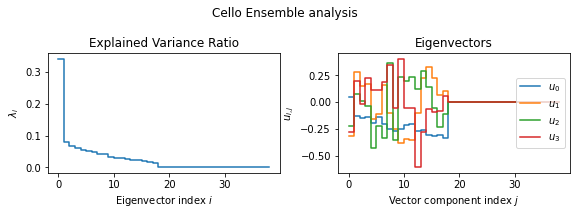

In [6]:
def plot_ensemble_pca(pca, instrument_name):
    fig, (var_ax, vec_ax) = plt.subplots(1, 2, figsize=(8.2, 3))

    fig.suptitle(f"{instrument_name} Ensemble analysis")

    var_ax.plot(pca.explained_variance_ratio_, ds='steps-post')
    var_ax.set_title("Explained Variance Ratio")
    var_ax.set_xlabel("Eigenvector index $i$")
    var_ax.set_ylabel("$\lambda_i$")

    vec_ax.set_title("Eigenvectors")
    vec_ax.set_xlabel("Vector component index $j$")
    vec_ax.set_ylabel("$u_{i,j}$")
    for i, vec in enumerate(pca.components_[:4]):
        vec_ax.plot(vec, label=f'$u_{i}$', ds='steps-post')
    vec_ax.legend(loc='right')

    fig.tight_layout()

pca = cello_pipeline[-1]
plot_ensemble_pca(pca, "Cello")
plt.savefig(GFX_PATH / "4-cello-ensemble.eps")

Let's look at the trajectories of some randomly chosen samples. X axes denote
the analysis frame index, Y axis the control parameter value.  We show the
trajectories of the 3 most significant control parameters for 10 samples. 

Empty plots mean that the analysis failed in preprocessing: When performing
timbre filtering, we discard timbre vectors that have at least one hole in the
_reliable_ partials. If an audio sample contains no values at all for a partial
that was deemed reliable, all timbre vectors are discarded and the PCA analysis
will fail.

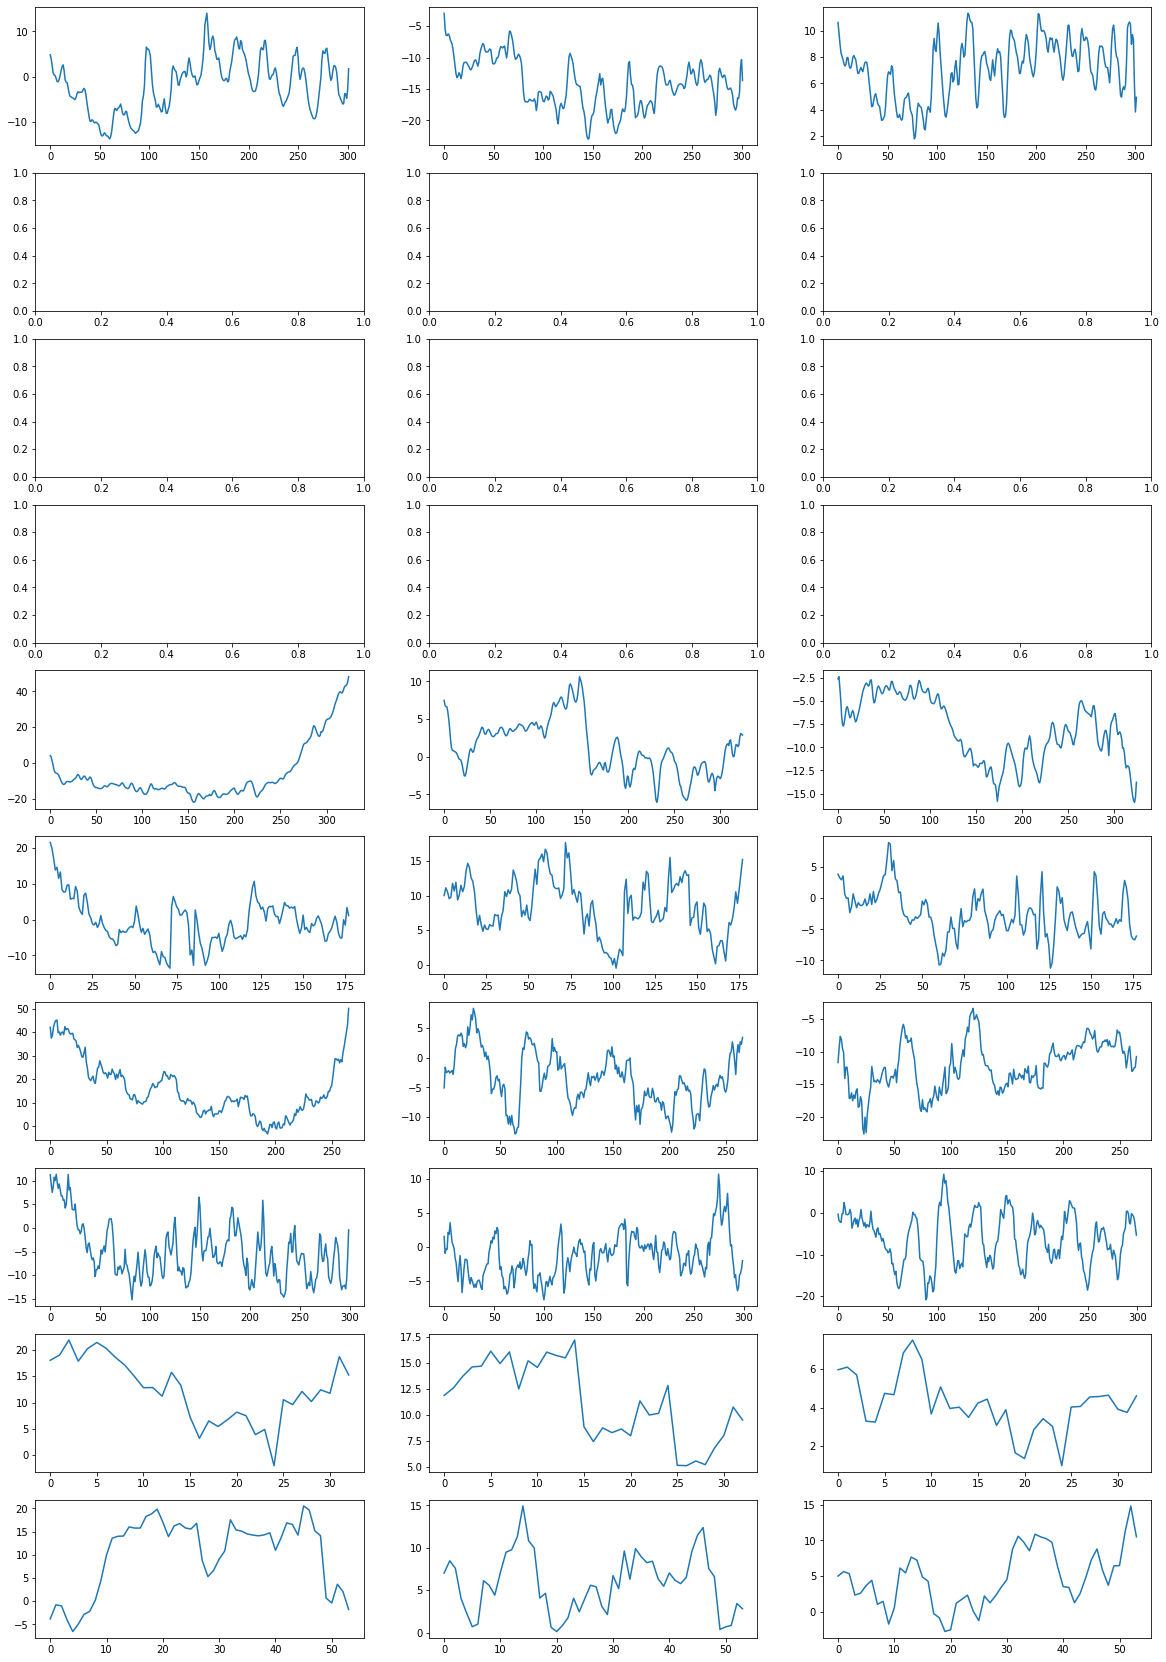

In [7]:
fig, axs = plt.subplots(10, 3, figsize=(20, 30))
for sample_ix, filename in enumerate(cello_df.index.unique('filename').to_series().sample(10, random_state=42)):
    sample_df = cello_df.loc[filename]
    try:
        sample_trans = cello_pipeline.transform(np.abs(sample_df.loc[:, "coefs-0":"coefs-39"].to_numpy()))
    except NoCompleteTimbreError:
        continue
    for j, ax in enumerate(axs[sample_ix]):
        ax.plot(sample_trans[:, j])


Let's see what each eigenvector does to the timbre: (We'll look at the four most significant eigenvectors)

In [8]:
def make_axis_asig_oscillating(mean, ui, scale, note, f=0.5) -> pya.Asig:
    ts = np.linspace(0, 4, 4*int(44100 // 256))
    dbs = mean.reshape(1, -1) + ui.reshape(1, -1) * scale * np.sin(2*np.pi * ts * f).reshape(-1, 1)
    ampls = pya.dbamp(dbs)
    ampls = ampls / ampls.sum(axis=1).reshape(-1, 1) * 0.1
    return ph.pvoc.additive_resynth(librosa.note_to_hz(note), ampls)

cello_axis_asigs = []
for i in range(4):
    scale = np.std(trans[:, i])
    ui = pca.components_[i]
    mean = pca.mean_
    asig = make_axis_asig_oscillating(mean, ui, 2*scale, 'G3')
    asig.save_wavfile(str(WAVS_PATH / f'ch4_cello-ensemble-pca-u{i}.wav'))
    cello_axis_asigs.append(asig)

(1, 1) (1, 1) (688, 39)
(1, 1) (1, 1) (688, 39)
(1, 1) (1, 1) (688, 39)
(1, 1) (1, 1) (688, 39)


In [9]:
# Uncomment for playback
# u0
# cello_axis_asig[0].play()
# u1
# cello_axis_asig[1].play()
# u2
# cello_axis_asig[2].play()
# u3
# cello_axis_asig[3].play()

Let's see if we can find some corellations between control parameters and sample
labels. Since the sample labels do not change the course of the sample, we compute 
corellation between the _mean_ of the control parameters and
the labels.

We will add some more features:
* `dynamic_int` is just a mapping from the dynamic (i.e. the loudness the
  instrument was played) to an integer, so that we can use it in corellation
  analysis.  
* `minimum_fret`: A note on the guitar can be played on different
  strings, resulting in different timbres. For this dataset, we might expect
  that each note was played on the string that
  allowed to use the lowest fret possible, resulting in the richest timbre.
  Assuming this is true, we can calculate `minimum_fret` to perform corellation
  analysis between the timbre and the fret index.

In [10]:
# lets load the dataset without expanding ndarrays. This way, the
# this analysis is more convenient.
cello_sample_df = ph.dataset.open_dataset(CELLO_PATH)

# First, let's add some more inferred fields:

# Integer representation of dynamic
dynamics_ints = {
    'pianissimo':  0,
    'piano':       1,
    'mezzo-piano': 2,
    'mezzo-forte': 3,
    'forte':       4,
    'fortissimo':  5
}
cello_sample_df['dynamic_int'] = cello_sample_df.dynamic.apply(lambda d: dynamics_ints[d])

# Guess the fret index that the note was played on
cello_empty_string_midis = librosa.note_to_midi(['C2', 'G2', 'D3', 'A3'])
possible_frets = cello_sample_df.midi.to_numpy().reshape(-1, 1) - cello_empty_string_midis.reshape(1, -1)
possible_frets[possible_frets < 0] = np.inf
minimum_fret = np.amin(possible_frets, axis=1)
cello_sample_df['minimum_fret'] = minimum_fret

# Compute mean control parameters
for fname, row in cello_sample_df.iterrows():
    ampls = np.abs(row.coefs)
    try:
        sample_trans = cello_pipeline.transform(ampls)
    except NoCompleteTimbreError:
        continue
    means = np.mean(sample_trans, axis=0)
    cello_sample_df.loc[fname, ["mean-alpha0", "mean-alpha1", "mean-alpha2", "mean-alpha3"]] = means[:4]

In [11]:
cello_sample_df.loc[:, ['midi', 'dynamic_int', 'minimum_fret', 'harmonic_r2', 'mean-alpha0',
                       'mean-alpha1', 'mean-alpha2', 'mean-alpha3']].corr()

,midi,dynamic_int,minimum_fret,harmonic_r2,mean-alpha0,mean-alpha1,mean-alpha2,mean-alpha3
midi,1.000000,0.051510,0.885666,0.375403,0.454891,-0.018490,-0.083263,-0.198994
dynamic_int,0.051510,1.000000,0.039716,0.028761,-0.434111,-0.081852,0.052683,-0.219672
minimum_fret,0.885666,0.039716,1.000000,0.204056,0.386444,0.261909,-0.071388,-0.248922
harmonic_r2,0.375403,0.028761,0.204056,1.000000,-0.134295,-0.073507,-0.125083,-0.104903
mean-alpha0,0.454891,-0.434111,0.386444,-0.134295,1.000000,0.043800,-0.039556,-0.088681
mean-alpha1,-0.018490,-0.081852,0.261909,-0.073507,0.043800,1.000000,0.012992,-0.030416
mean-alpha2,-0.083263,0.052683,-0.071388,-0.125083,-0.039556,0.012992,1.000000,-0.012045
mean-alpha3,-0.198994,-0.219672,-0.248922,-0.104903,-0.088681,-0.030416,-0.012045,1.000000


# Guitar Ensemble PCA
Moving on to the guitar, we'll perform the same steps as above. The only difference is that we have to take the preprocessing steps for each sample separately.

In [12]:
guitar_df = ph.dataset.open_dataset(GUITAR_PATH)
guitar_pipeline = make_pipeline(
    DropDCTransformer(),
    DBTransformer(),
    HoleImputer(hole_size_limit=10),
    RidgeSubNoiseImputer(constant_value=-240),
    PCA()
)
preprocessed = []
for filename, row in guitar_df.iterrows():
    prep = guitar_pipeline[:-1].fit_transform(np.abs(row.coefs))
    preprocessed.append(prep)
trans = guitar_pipeline[-1].fit_transform(np.vstack(preprocessed))

guitar_df = ph.dataset.expand_ndarrays(guitar_df, ['freqs', 'coefs'])

Explained variance and eigenvector plots:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


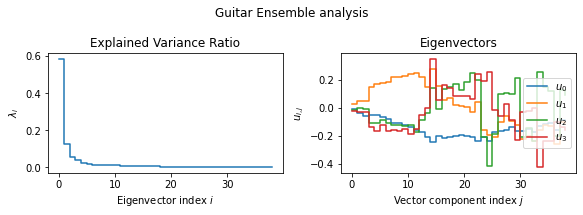

In [13]:
pca = guitar_pipeline[-1]
plot_ensemble_pca(pca, "Guitar")
plt.savefig(GFX_PATH / "4-guitar-ensemble.eps")

Again, plotting the trajectories of the first three control parameters for 10 random samples:

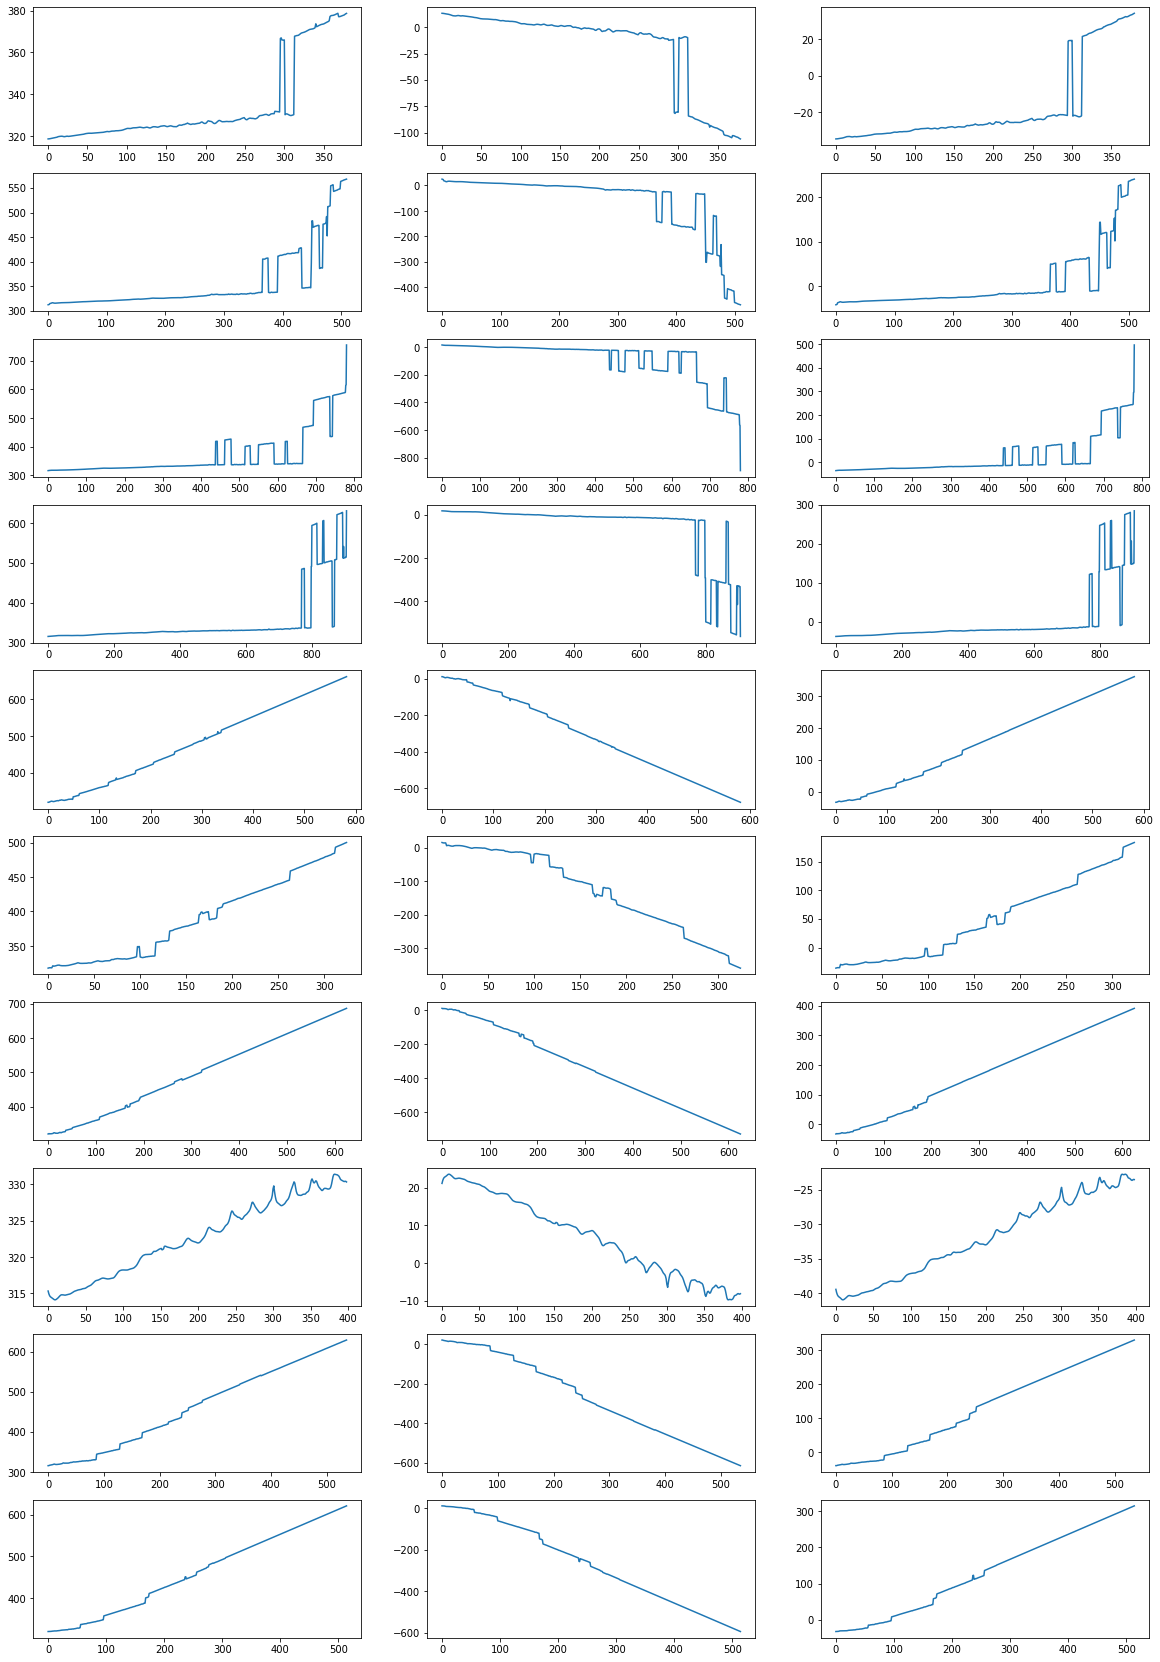

In [14]:
fig, axs = plt.subplots(10, 3, figsize=(20, 30))
for sample_ix, filename in enumerate(guitar_df.index.unique('filename').to_series().sample(10, random_state=1337)):
    sample_df = guitar_df.loc[filename]
    sample_trans = guitar_pipeline.transform(np.abs(sample_df.loc[:, "coefs-0":"coefs-39"].to_numpy()))
    for j, ax in enumerate(axs[sample_ix]):
        ax.plot(sample_trans[:, j])

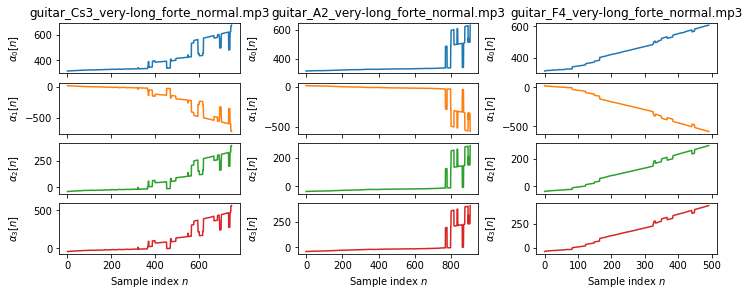

In [15]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
fig, axs = plt.subplots(4, 3, figsize=(10, 4), constrained_layout=True, sharex='col')
for sample_ix, filename in enumerate(guitar_df.index.unique('filename').to_series().sample(3, random_state=42)):
    axs[0, sample_ix].set_title(filename)
    sample_df = guitar_df.loc[filename]
    sample_trans = guitar_pipeline.transform(np.abs(sample_df.loc[:, "coefs-0":"coefs-39"].to_numpy()))
    for j, (ax, color) in enumerate(zip(axs[:, sample_ix], colors)):
        ax.plot(sample_trans[:, j], color=color)
        ax.set_ylabel(f"$\\alpha_{j}[n]$")
for ax in axs[-1]:
    ax.set_xlabel("Sample index $n$")
fig.align_ylabels()
plt.savefig(GFX_PATH / '4-guitar-ensemble-control-parameters.eps')

In [16]:
guitar_axis_asigs = []
for i in range(4):
    scale = np.std(trans[:, i])
    ui = pca.components_[i]
    mean = pca.mean_
    asig = make_axis_asig_oscillating(mean, ui, 2*scale, 'A4')
    asig.save_wavfile(str(WAVS_PATH / f'ch4_guitar-ensemble-pca-u{i}.wav'))
    guitar_axis_asigs.append(asig)

(1, 1) (1, 1) (688, 39)
(1, 1) (1, 1) (688, 39)
(1, 1) (1, 1) (688, 39)
(1, 1) (1, 1) (688, 39)


In [17]:
# Uncomment for playback
# u0
# cello_axis_asig[0].play()
# u1
# cello_axis_asig[1].play()
# u2
# cello_axis_asig[2].play()
# u3
# cello_axis_asig[3].play()

In [18]:
# lets load the dataset without expanding ndarrays. This way, the
# this analysis is more convenient.
guitar_sample_df = ph.dataset.open_dataset(GUITAR_PATH)

# First, let's add some more inferred fields:

# Integer representation of dynamic
dynamics_ints = {
    'piano': 0,
    'forte': 1,
}
guitar_sample_df['dynamic_int'] = guitar_sample_df.dynamic.apply(lambda d: dynamics_ints[d])

# Guess the fret index that the note was played on
guitar_empty_string_midis = librosa.note_to_midi(['E2', 'A2', 'D3', 'G3', 'B3', 'E4'])
possible_frets = guitar_sample_df.midi.to_numpy().reshape(-1, 1) - guitar_empty_string_midis.reshape(1, -1)
possible_frets[possible_frets < 0] = np.inf
minimum_fret = np.amin(possible_frets, axis=1)
guitar_sample_df['minimum_fret'] = minimum_fret

# Compute mean control parameters
for fname, row in guitar_sample_df.iterrows():
    ampls = np.abs(row.coefs)
    sample_trans = guitar_pipeline.transform(ampls)
    means = np.mean(sample_trans, axis=0)
    guitar_sample_df.loc[fname, ["mean-alpha0", "mean-alpha1", "mean-alpha2", "mean-alpha3"]] = means[:4]

In [19]:
guitar_sample_df.loc[:, ['midi', 'dynamic_int', 'minimum_fret', 'harmonic_r2', 'mean-alpha0',
                         'mean-alpha1', 'mean-alpha2', 'mean-alpha3']].corr()

,midi,dynamic_int,minimum_fret,harmonic_r2,mean-alpha0,mean-alpha1,mean-alpha2,mean-alpha3
midi,1.000000,0.026958,0.718109,-0.147222,0.472524,-0.473341,0.473970,0.476116
dynamic_int,0.026958,1.000000,0.010100,0.518304,-0.102497,0.099994,-0.097764,-0.100630
minimum_fret,0.718109,0.010100,1.000000,-0.294816,0.024170,-0.027748,0.030559,0.031780
harmonic_r2,-0.147222,0.518304,-0.294816,1.000000,-0.049477,0.049055,-0.047590,-0.049926
mean-alpha0,0.472524,-0.102497,0.024170,-0.049477,1.000000,-0.999520,0.998722,0.999119
mean-alpha1,-0.473341,0.099994,-0.027748,0.049055,-0.999520,1.000000,-0.999765,-0.999872
mean-alpha2,0.473970,-0.097764,0.030559,-0.047590,0.998722,-0.999765,1.000000,0.999867
mean-alpha3,0.476116,-0.100630,0.031780,-0.049926,0.999119,-0.999872,0.999867,1.000000


In [20]:
guitar_sample_df.loc[:, ['mean-alpha0', 'mean-alpha1', 'mean-alpha2', 'mean-alpha3']]

,mean-alpha0,mean-alpha1,mean-alpha2,mean-alpha3
filename,,,,
guitar_A2_very-long_forte_normal.mp3,352.686488,-50.638363,0.921082,14.607563
guitar_A2_very-long_piano_normal.mp3,352.654770,-48.061947,-1.532717,12.133728
guitar_A3_very-long_forte_normal.mp3,442.622773,-233.967155,108.087241,166.507185
guitar_A3_very-long_piano_normal.mp3,442.076904,-233.090403,107.333268,166.323256
guitar_A4_very-long_forte_normal.mp3,463.915644,-276.738789,131.049455,201.448053
...,...,...,...,...
guitar_Gs3_very-long_forte_normal.mp3,346.580745,-40.275697,-3.809051,6.943206
guitar_Gs3_very-long_piano_normal.mp3,390.671918,-130.780321,48.214163,82.179157
guitar_Gs4_very-long_forte_normal.mp3,470.976603,-291.935479,140.293271,214.795348
